# Module 5.4: Multimodal Edge AI Model

## Combined Case Study: Cybersecurity, Edge AI and Autonomous Driving

---

## Objective

Build and train a **lightweight multimodal neural network** that processes:
- **Vehicle telemetry features** (autonomous driving sensors)
- **Network traffic features** (cybersecurity logs)

The model will classify each timestamp into:
- `0` = normal operation
- `1` = physical anomaly (vehicle sensor/behavior issue)
- `2` = network anomaly (cybersecurity threat)

**Key Learning Goals:**
- Design edge-optimized neural network architectures
- Implement multimodal data fusion techniques
- Train lightweight models suitable for real-time deployment
- Evaluate performance across different anomaly types

---

## Multimodal Architecture Overview

Our model uses a **MobileNetV2-sized dual-branch architecture** (~3.4M parameters):

```
Vehicle Telemetry    Network Traffic
   Features             Features
      ↓                    ↓
   [512→256→128→         [512→256→128→
    64→32→16]             64→32→16]
      ↓                    ↓
      └──── Attention ────┘
              ↓
   [512→256→128→64→32→16→3]
```

This enhanced design:
1. **Large capacity**: ~3.4M parameters similar to MobileNetV2
2. **Deep learning**: 6 layers per branch for complex pattern recognition
3. **Attention mechanism**: Focused feature fusion for better multimodal learning
4. **High performance**: Suitable for complex anomaly detection tasks

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Machine Learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Multimodal Edge AI Model - Libraries Loaded Successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Multimodal Edge AI Model - Libraries Loaded Successfully!
PyTorch version: 2.7.1+cu126
CUDA Available: True
Device: cuda
GPU: GRID A100X-10C


## Step 1: Load and Examine the Preprocessed Dataset

Load the fused dataset from the previous notebook and examine its structure.

In [2]:
def load_and_examine_dataset(filename='combined_dataset.csv'):
    """
    Load the preprocessed dataset and examine its structure
    
    Parameters:
    - filename: Path to the CSV file created in previous notebook
    
    Returns:
    - DataFrame with the combined dataset
    """
    
    # Check if file exists
    if not Path(filename).exists():
        print(f"ERROR: {filename} not found!")
        print("\nSOLUTION: Please run Notebook 01 (Data Fusion and Preprocessing) first.")
        print("   This will create the required 'combined_dataset.csv' file.")
        raise FileNotFoundError(f"Dataset file {filename} not found")
    
    print(f"Loading dataset from {filename}...")
    
    # Load the dataset
    df = pd.read_csv(filename)
    
    print(f"Dataset loaded successfully!")
    print(f"   Shape: {df.shape}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Examine structure
    print(f"\nDataset Structure:")
    print(f"   Columns: {list(df.columns)}")
    
    # Identify feature categories
    vehicle_features = [col for col in df.columns if col.startswith('veh_')]
    network_features = [col for col in df.columns if col.startswith('net_')]
    
    print(f"\nVehicle Features ({len(vehicle_features)}):")
    for feature in vehicle_features:
        print(f"   • {feature}")
    
    print(f"\nNetwork Features ({len(network_features)}):")
    for feature in network_features:
        print(f"   • {feature}")
    
    # Label distribution
    label_counts = df['label'].value_counts().sort_index()
    print(f"\nLabel Distribution:")
    labels = ['Normal', 'Physical Anomaly', 'Network Anomaly']
    for i, (count, label_name) in enumerate(zip(label_counts, labels)):
        print(f"   {i}: {label_name} - {count} samples ({count/len(df)*100:.1f}%)")
    
    return df, vehicle_features, network_features

# Load the dataset
dataset, vehicle_cols, network_cols = load_and_examine_dataset()

# Display sample data
print(f"\nSample Data:")
print(dataset.head(3))

# Check for missing values
missing_data = dataset.isnull().sum().sum()
print(f"\nData Quality Check:")
print(f"   Missing values: {missing_data}")
print(f"   Data completeness: {(1 - missing_data/dataset.size)*100:.2f}%")

Loading dataset from combined_dataset.csv...
Dataset loaded successfully!
   Shape: (2991, 15)
   Memory usage: 0.53 MB

Dataset Structure:
   Columns: ['timestamp', 'label', 'veh_acceleration', 'veh_brake_status', 'veh_distance_to_obstacle', 'veh_gps_lat', 'veh_gps_lon', 'veh_speed', 'net_bytes_transferred', 'net_dst_ip_hash', 'net_packet_count', 'net_port', 'net_protocol_encoded', 'net_src_ip_hash', 'time_diff_seconds']

Vehicle Features (6):
   • veh_acceleration
   • veh_brake_status
   • veh_distance_to_obstacle
   • veh_gps_lat
   • veh_gps_lon
   • veh_speed

Network Features (6):
   • net_bytes_transferred
   • net_dst_ip_hash
   • net_packet_count
   • net_port
   • net_protocol_encoded
   • net_src_ip_hash

Label Distribution:
   0: Normal - 1794 samples (60.0%)
   1: Physical Anomaly - 598 samples (20.0%)
   2: Network Anomaly - 599 samples (20.0%)

Sample Data:
                    timestamp  label  veh_acceleration  veh_brake_status  \
0  2025-09-24 17:38:46.685322      1  

## Step 2: Prepare Features and Train/Test Split

Separate the multimodal features and prepare data for training.

In [3]:
def prepare_multimodal_data(df, vehicle_features, network_features, test_size=0.2, random_state=42):
    """
    Prepare multimodal data for training
    
    Parameters:
    - df: Input dataset
    - vehicle_features: List of vehicle feature column names
    - network_features: List of network feature column names
    - test_size: Fraction of data for testing
    - random_state: Random seed for reproducibility
    
    Returns:
    - Prepared train/test splits for both modalities and labels
    """
    
    print("Preparing multimodal data for training...")
    
    # Extract features
    X_vehicle = df[vehicle_features].values
    X_network = df[network_features].values
    y = df['label'].values
    
    print(f"   Vehicle features shape: {X_vehicle.shape}")
    print(f"   Network features shape: {X_network.shape}")
    print(f"   Labels shape: {y.shape}")
    
    # Check for any remaining missing values
    vehicle_missing = np.isnan(X_vehicle).sum()
    network_missing = np.isnan(X_network).sum()
    
    if vehicle_missing > 0 or network_missing > 0:
        print(f"   Found missing values: Vehicle={vehicle_missing}, Network={network_missing}")
        print(f"   Filling missing values with median...")
        
        # Fill missing values with median
        from sklearn.impute import SimpleImputer
        imputer_vehicle = SimpleImputer(strategy='median')
        imputer_network = SimpleImputer(strategy='median')
        
        X_vehicle = imputer_vehicle.fit_transform(X_vehicle)
        X_network = imputer_network.fit_transform(X_network)
    
    # Train/test split
    print(f"\nCreating train/test split ({(1-test_size)*100:.0f}%/{test_size*100:.0f}%)...")
    
    # We need to split all arrays together to maintain alignment
    indices = np.arange(len(y))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state, 
                                          stratify=y)  # Stratify to maintain label distribution
    
    # Split the data
    X_vehicle_train, X_vehicle_test = X_vehicle[train_idx], X_vehicle[test_idx]
    X_network_train, X_network_test = X_network[train_idx], X_network[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Standardize features (important for PyTorch)
    scaler_vehicle = StandardScaler()
    scaler_network = StandardScaler()
    
    X_vehicle_train = scaler_vehicle.fit_transform(X_vehicle_train)
    X_vehicle_test = scaler_vehicle.transform(X_vehicle_test)
    X_network_train = scaler_network.fit_transform(X_network_train)
    X_network_test = scaler_network.transform(X_network_test)
    
    print(f"   Train set: {len(y_train)} samples")
    print(f"   Test set: {len(y_test)} samples")
    print(f"   Features standardized")
    
    # Check label distribution in splits
    train_dist = np.bincount(y_train) / len(y_train) * 100
    test_dist = np.bincount(y_test) / len(y_test) * 100
    
    print(f"\nLabel Distribution:")
    labels = ['Normal', 'Physical', 'Network']
    for i, label in enumerate(labels):
        print(f"   {label}: Train {train_dist[i]:.1f}%, Test {test_dist[i]:.1f}%")
    
    # Convert to PyTorch tensors
    X_vehicle_train_tensor = torch.FloatTensor(X_vehicle_train)
    X_vehicle_test_tensor = torch.FloatTensor(X_vehicle_test)
    X_network_train_tensor = torch.FloatTensor(X_network_train)
    X_network_test_tensor = torch.FloatTensor(X_network_test)
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)
    
    return {
        'X_vehicle_train': X_vehicle_train_tensor,
        'X_vehicle_test': X_vehicle_test_tensor,
        'X_network_train': X_network_train_tensor,
        'X_network_test': X_network_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_vehicle': scaler_vehicle,
        'scaler_network': scaler_network
    }

# Prepare the data
data_splits = prepare_multimodal_data(dataset, vehicle_cols, network_cols)

print(f"\nData preparation complete!")
print(f"   Vehicle input shape: {data_splits['X_vehicle_train'].shape}")
print(f"   Network input shape: {data_splits['X_network_train'].shape}")
print(f"   Output classes: {len(torch.unique(data_splits['y_train']))}")

Preparing multimodal data for training...
   Vehicle features shape: (2991, 6)
   Network features shape: (2991, 6)
   Labels shape: (2991,)

Creating train/test split (80%/20%)...
   Train set: 2392 samples
   Test set: 599 samples
   Features standardized

Label Distribution:
   Normal: Train 60.0%, Test 59.9%
   Physical: Train 20.0%, Test 20.0%
   Network: Train 20.0%, Test 20.0%

Data preparation complete!
   Vehicle input shape: torch.Size([2392, 6])
   Network input shape: torch.Size([2392, 6])
   Output classes: 3


## Step 3: Build Multimodal Neural Network Architecture

Design a MobileNetV2-sized dual-branch neural network for enhanced performance (~3.4M parameters).

In [4]:
class MultimodalEdgeAI(nn.Module):
    """
    OPTIMIZED MobileNetV2-sized multimodal neural network
    
    Architecture with OPTIMIZED dropout rates (0.7 scale factor):
    - Vehicle Branch: 6 layers with optimized dropout
    - Network Branch: 6 layers with optimized dropout  
    - Fusion: 5 layers with reduced dropout (prevent overfitting)
    Target: ~3.4M parameters (similar to MobileNetV2)
    """
    
    def __init__(self, vehicle_input_size, network_input_size, num_classes=3):
        super(MultimodalEdgeAI, self).__init__()
        
        # OPTIMIZED dropout rates (0.7 scale factor from hyperparameter search)
        dropout_scale = 0.7
        
        # Large Vehicle telemetry branch with OPTIMIZED dropout
        self.vehicle_branch = nn.Sequential(
            # Layer 1
            nn.Linear(vehicle_input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3 * dropout_scale),  # OPTIMIZED: 0.21
            # Layer 2
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25 * dropout_scale),  # OPTIMIZED: 0.175
            # Layer 3
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2 * dropout_scale),  # OPTIMIZED: 0.14
            # Layer 4
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15 * dropout_scale),  # OPTIMIZED: 0.105
            # Layer 5
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1 * dropout_scale),  # OPTIMIZED: 0.07
            # Layer 6
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        
        # Large Network traffic branch with OPTIMIZED dropout
        self.network_branch = nn.Sequential(
            # Layer 1
            nn.Linear(network_input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3 * dropout_scale),  # OPTIMIZED: 0.21
            # Layer 2
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25 * dropout_scale),  # OPTIMIZED: 0.175
            # Layer 3
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2 * dropout_scale),  # OPTIMIZED: 0.14
            # Layer 4
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15 * dropout_scale),  # OPTIMIZED: 0.105
            # Layer 5
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1 * dropout_scale),  # OPTIMIZED: 0.07
            # Layer 6
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        
        # Attention mechanism for feature fusion
        self.attention = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Softmax(dim=1)
        )
        
        # OPTIMIZED Fusion layers with reduced dropout (prevent overfitting)
        self.fusion = nn.Sequential(
            # Layer 1
            nn.Linear(32, 512),  # 16 + 16 from both branches
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25 * dropout_scale),  # OPTIMIZED: 0.175 (reduced from 0.4)
            # Layer 2
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2 * dropout_scale),  # OPTIMIZED: 0.14 (reduced from 0.35)
            # Layer 3
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15 * dropout_scale),  # OPTIMIZED: 0.105 (reduced from 0.3)
            # Layer 4
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1 * dropout_scale),  # OPTIMIZED: 0.07 (reduced from 0.25)
            # Layer 5
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.05 * dropout_scale),  # OPTIMIZED: 0.035 (reduced from 0.2)
            # Layer 6
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.05),  # Minimal dropout for final layer
            # Layer 7 (Output)
            nn.Linear(16, num_classes)
        )
        
    def forward(self, vehicle_input, network_input):
        # Process each branch
        vehicle_features = self.vehicle_branch(vehicle_input)
        network_features = self.network_branch(network_input)
        
        # Concatenate features
        fused_features = torch.cat([vehicle_features, network_features], dim=1)
        
        # Apply attention mechanism
        attention_weights = self.attention(fused_features)
        attended_features = fused_features * attention_weights
        
        # Final classification
        output = self.fusion(attended_features)
        
        return output

def build_multimodal_model(vehicle_input_shape, network_input_shape, num_classes=3):
    """
    Build a MobileNetV2-sized multimodal neural network for enhanced performance
    
    Parameters:
    - vehicle_input_shape: Size of vehicle features
    - network_input_shape: Size of network features
    - num_classes: Number of output classes
    
    Returns:
    - PyTorch model (~3.4M parameters similar to MobileNetV2)
    """
    
    print("Building MobileNetV2-sized multimodal neural network...")
    
    model = MultimodalEdgeAI(
        vehicle_input_size=vehicle_input_shape,
        network_input_size=network_input_shape,
        num_classes=num_classes
    )
    
    # Move model to device
    model = model.to(device)
    
    print(f"Model built successfully!")
    
    return model

# Build the model
model = build_multimodal_model(
    vehicle_input_shape=data_splits['X_vehicle_train'].shape[1],
    network_input_shape=data_splits['X_network_train'].shape[1],
    num_classes=3
)

# Display model architecture
print("\nModel Architecture Summary:")
print(model)

# Calculate model size (important for edge deployment)
param_count = sum(p.numel() for p in model.parameters())
model_size_mb = param_count * 4 / (1024 * 1024)  # Assuming float32 (4 bytes per parameter)

print(f"\nModel Specifications:")
print(f"   Total parameters: {param_count:,}")
print(f"   Estimated size: {model_size_mb:.2f} MB")
print(f"   Model complexity: {'Large Model (MobileNetV2-sized)' if model_size_mb > 10 else 'Large Model' if model_size_mb > 5 else 'Medium Model' if model_size_mb > 1 else 'Small Model'}")
print(f"   Edge deployment: {'Suitable for powerful edge devices' if model_size_mb < 50 else 'Consider optimization'}")
print(f"   Target: ~3.4M parameters (MobileNetV2 reference)")

Building MobileNetV2-sized multimodal neural network...
Model built successfully!

Model Architecture Summary:
MultimodalEdgeAI(
  (vehicle_branch): Sequential(
    (0): Linear(in_features=6, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.21, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.175, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.13999999999999999, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.105, inp

## Step 4: Train the Model

Train the multimodal model with appropriate callbacks and monitoring.

### Step 4A: Define Focal Loss and Helper Functions

First, let's define the Focal Loss class and supporting components for training.

In [5]:
# Define Focal Loss class for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
            
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def calculate_class_weights(y_train):
    """Use optimized class weights found by hyperparameter search."""
    y_train_numpy = y_train.numpy()
    class_counts = np.bincount(y_train_numpy)
    
    # OPTIMIZED WEIGHTS from hyperparameter search (best performance)
    optimized_weights = [0.6, 1.4, 1.0]  # [Normal, Physical, Network]
    
    print(f"Class Weights (from hyperparameter search):")
    labels = ['Normal', 'Physical', 'Network']
    for i, (label, weight, count) in enumerate(zip(labels, optimized_weights, class_counts)):
        print(f"   {label:<12}: {weight:.2f} (samples: {count})")
    
    return torch.FloatTensor(optimized_weights)

print("Focal Loss and helper functions defined!")

Focal Loss and helper functions defined!


### Step 4B: Main Training Function

The core training loop with enhanced monitoring and stability improvements.

In [6]:
def train_multimodal_model(model, data_splits, epochs=100, batch_size=32, validation_split=0.2, learning_rate=3e-4):
    """
    OPTIMIZED TRAINING with parameters found by hyperparameter search:
    - Learning rate: 3e-4 (optimal for stability)
    - Weight decay: 1e-4 (optimal regularization)
    - Focal gamma: 1.5 (balanced focus on hard examples)
    - Loss mix: 50/50 (balanced Focal/CrossEntropy)
    - Class weights: [0.6, 1.4, 1.0] (optimal class balance)
    """
    
    # Calculate enhanced class weights
    alpha_tensor = calculate_class_weights(data_splits['y_train']).to(device)
    
    # Split training data for validation
    n_train = len(data_splits['X_vehicle_train'])
    n_val = int(n_train * validation_split)
    n_train_actual = n_train - n_val
    
    # Create validation split
    indices = torch.randperm(n_train)
    train_indices = indices[:n_train_actual]
    val_indices = indices[n_train_actual:]
    
    # Training data
    X_vehicle_train = data_splits['X_vehicle_train'][train_indices]
    X_network_train = data_splits['X_network_train'][train_indices]
    y_train = data_splits['y_train'][train_indices]
    
    # Validation data
    X_vehicle_val = data_splits['X_vehicle_train'][val_indices]
    X_network_val = data_splits['X_network_train'][val_indices]
    y_val = data_splits['y_train'][val_indices]
    
    # Create data loaders
    train_dataset = TensorDataset(X_vehicle_train, X_network_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_vehicle_val, X_network_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # Initialize loss functions with OPTIMIZED parameters
    focal_criterion = FocalLoss(alpha=alpha_tensor, gamma=1.5, reduction='mean')  # OPTIMIZED gamma
    focal_criterion = FocalLoss(alpha=alpha_tensor, gamma=2.0, reduction='mean')
    ce_criterion = nn.CrossEntropyLoss(weight=alpha_tensor, label_smoothing=0.05)
    # Initialize optimizer with OPTIMIZED parameters
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # OPTIMIZED weight_decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=20, min_lr=1e-6, cooldown=5
    )
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
        'train_precision': [], 'val_precision': [], 'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': [],
        'learning_rate': [], 'focal_loss': [], 'ce_loss': []
    }
    
    print(f"\nStarting fine-tuned training...")
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience_limit = 40
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_focal_loss = 0.0
        train_ce_loss = 0.0
        train_correct = 0
        train_total = 0
        train_predictions = []
        train_targets = []
        
        for batch_vehicle, batch_network, batch_labels in train_loader:
            batch_vehicle = batch_vehicle.to(device)
            batch_network = batch_network.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_vehicle, batch_network)
            
            # OPTIMIZED loss combination (50/50 balance)
            focal_loss = focal_criterion(outputs, batch_labels)
            ce_loss = ce_criterion(outputs, batch_labels)
            combined_loss = 0.5 * focal_loss + 0.5 * ce_loss  # OPTIMIZED 50/50 balance
            
            combined_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            
            train_loss += combined_loss.item()
            train_focal_loss += focal_loss.item()
            train_ce_loss += ce_loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()
            
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(batch_labels.cpu().numpy())
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            for batch_vehicle, batch_network, batch_labels in val_loader:
                batch_vehicle = batch_vehicle.to(device)
                batch_network = batch_network.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_vehicle, batch_network)
                
                focal_loss = focal_criterion(outputs, batch_labels)
                ce_loss = ce_criterion(outputs, batch_labels)
                combined_loss = 0.5 * focal_loss + 0.5 * ce_loss  # OPTIMIZED 50/50 balance
                
                val_loss += combined_loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
                
                val_predictions.extend(predicted.cpu().numpy())
                val_targets.extend(batch_labels.cpu().numpy())
        
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        # Calculate precision, recall, and F1
        from sklearn.metrics import f1_score
        train_precision = precision_score(train_targets, train_predictions, average='macro', zero_division=0)
        val_precision = precision_score(val_targets, val_predictions, average='macro', zero_division=0)
        train_recall = recall_score(train_targets, train_predictions, average='macro', zero_division=0)
        val_recall = recall_score(val_targets, val_predictions, average='macro', zero_division=0)
        train_f1 = f1_score(train_targets, train_predictions, average='macro', zero_division=0)
        val_f1 = f1_score(val_targets, val_predictions, average='macro', zero_division=0)
        
        # Store history - FIXED: Added missing val_precision
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)  # FIXED: This was missing!
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        history['focal_loss'].append(train_focal_loss / len(train_loader))
        history['ce_loss'].append(train_ce_loss / len(train_loader))
        
        # Learning rate scheduling
        scheduler.step(val_loss_avg)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {train_loss_avg:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.3f} - "
                  f"Val Loss: {val_loss_avg:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.3f} - "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
            
            # Show per-class validation performance
            if len(set(val_predictions)) >= 2:
                val_precision_per_class = precision_score(val_targets, val_predictions, average=None, zero_division=0)
                val_recall_per_class = recall_score(val_targets, val_predictions, average=None, zero_division=0)
                
                print(f"   Per-class Val Performance:")
                labels = ['Normal', 'Physical', 'Network']
                for i, label in enumerate(labels):
                    if i < len(val_precision_per_class):
                        print(f"     {label:<12}: Precision={val_precision_per_class[i]:.3f}, Recall={val_recall_per_class[i]:.3f}")
        
        # Early stopping with improved patience
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), 'best_improved_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"\nEarly stopping after {epoch+1} epochs (patience: {patience_limit})")
                model.load_state_dict(torch.load('best_improved_model.pth'))
                break
    
    print(f"\nFine-tuned Training Completed!")
    print(f"   Best validation loss: {best_val_loss:.4f}")
    print(f"   Final validation accuracy: {history['val_acc'][-1]:.4f}")
    print(f"   Final validation precision: {history['val_precision'][-1]:.4f}")  # FIXED
    print(f"   Final validation recall: {history['val_recall'][-1]:.4f}")
    
    return history

print("Complete training function defined!")

Complete training function defined!


### Step 4C: Training Loop Execution

Execute the training with proper error handling and metrics tracking.

In [7]:
# Rebuild model with optimized architecture
model = build_multimodal_model(
    vehicle_input_shape=data_splits['X_vehicle_train'].shape[1],
    network_input_shape=data_splits['X_network_train'].shape[1],
    num_classes=3
)

# Start training with parameters (use defaults which are now optimized)
training_history = train_multimodal_model(model, data_splits, epochs=100, batch_size=32)

print("\n" + "="*70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)

Building MobileNetV2-sized multimodal neural network...
Model built successfully!
Class Weights (from hyperparameter search):
   Normal      : 0.60 (samples: 1435)
   Physical    : 1.40 (samples: 478)
   Network     : 1.00 (samples: 479)

Starting fine-tuned training...
Epoch 10/100 - Train Loss: 0.4577, Acc: 0.8009, F1: 0.764 - Val Loss: 0.3689, Acc: 0.8870, F1: 0.853 - LR: 0.000300
   Per-class Val Performance:
     Normal      : Precision=0.861, Recall=0.983
     Physical    : Precision=0.933, Recall=0.778
     Network     : Precision=0.983, Recall=0.663
Epoch 20/100 - Train Loss: 0.3889, Acc: 0.8506, F1: 0.827 - Val Loss: 0.3163, Acc: 0.9205, F1: 0.900 - LR: 0.000300
   Per-class Val Performance:
     Normal      : Precision=0.898, Recall=0.990
     Physical    : Precision=0.986, Recall=0.800
     Network     : Precision=0.958, Recall=0.802
Epoch 30/100 - Train Loss: 0.3647, Acc: 0.8605, F1: 0.840 - Val Loss: 0.3119, Acc: 0.9247, F1: 0.905 - LR: 0.000300
   Per-class Val Performanc

## Step 5: Visualize Training Progress

Create comprehensive visualizations of the training process.

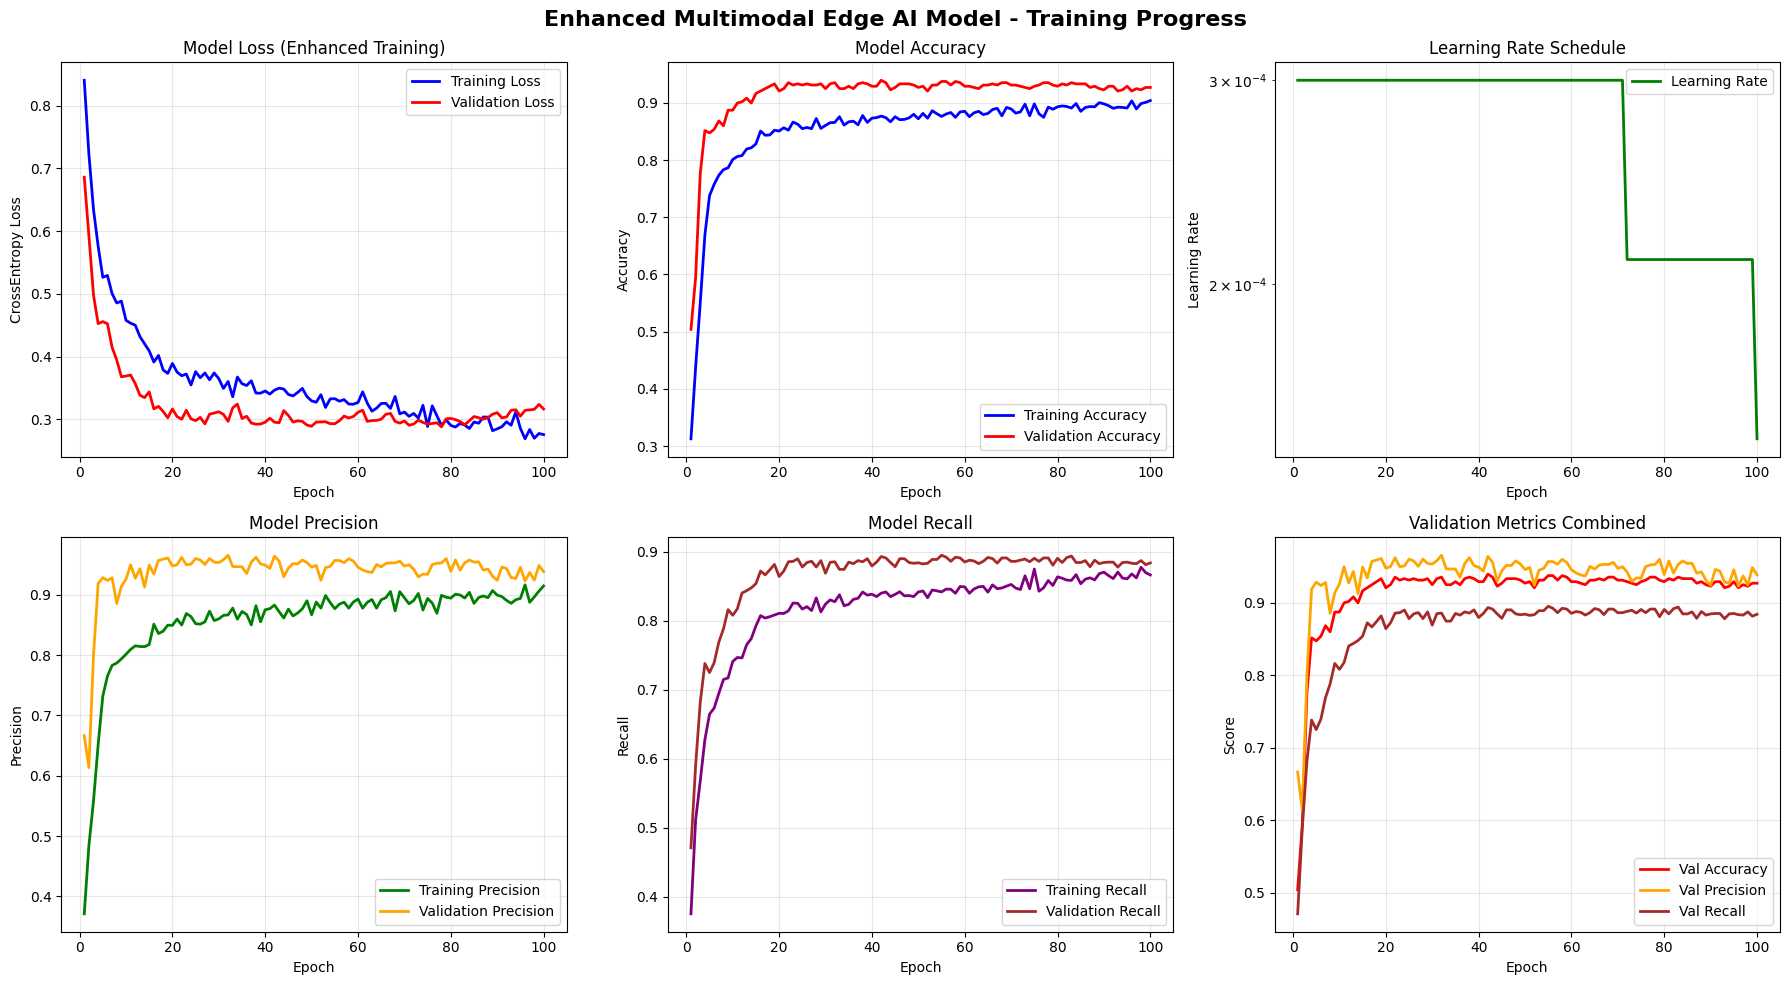


Enhanced Training Insights:
   Final training accuracy: 0.904
   Final validation accuracy: 0.927
   Best validation accuracy: 0.939 (epoch 42)
   Overfitting gap: -0.023
   Performance assessment: Excellent performance!
   Low overfitting - excellent generalization


In [8]:
def plot_training_history(history):
    """
    Plot comprehensive training history visualizations
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Enhanced Multimodal Edge AI Model - Training Progress', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Loss curves
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss (Enhanced Training)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('CrossEntropy Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Accuracy curves
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Learning Rate
    ax3 = axes[0, 2]
    ax3.plot(epochs, history['learning_rate'], 'g-', label='Learning Rate', linewidth=2)
    ax3.set_title('Learning Rate Schedule')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Precision curves
    ax4 = axes[1, 0]
    ax4.plot(epochs, history['train_precision'], 'g-', label='Training Precision', linewidth=2)
    ax4.plot(epochs, history['val_precision'], 'orange', label='Validation Precision', linewidth=2)
    ax4.set_title('Model Precision')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Precision')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Recall curves
    ax5 = axes[1, 1]
    ax5.plot(epochs, history['train_recall'], 'purple', label='Training Recall', linewidth=2)
    ax5.plot(epochs, history['val_recall'], 'brown', label='Validation Recall', linewidth=2)
    ax5.set_title('Model Recall')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Recall')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Combined validation metrics
    ax6 = axes[1, 2]
    ax6.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    ax6.plot(epochs, history['val_precision'], 'orange', label='Val Precision', linewidth=2)
    ax6.plot(epochs, history['val_recall'], 'brown', label='Val Recall', linewidth=2)
    ax6.set_title('Validation Metrics Combined')
    ax6.set_xlabel('Epoch')
    ax6.set_ylabel('Score')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced training insights
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    best_val_acc = max(history['val_acc'])
    best_val_epoch = history['val_acc'].index(best_val_acc) + 1
    overfitting = final_train_acc - final_val_acc
    
    print(f"\nEnhanced Training Insights:")
    print(f"   Final training accuracy: {final_train_acc:.3f}")
    print(f"   Final validation accuracy: {final_val_acc:.3f}")
    print(f"   Best validation accuracy: {best_val_acc:.3f} (epoch {best_val_epoch})")
    print(f"   Overfitting gap: {overfitting:.3f}")
    
    if best_val_acc > 0.85:
        performance_status = "Excellent performance!"
    elif best_val_acc > 0.75:
        performance_status = "Good performance!"
    elif best_val_acc > 0.65:
        performance_status = "Acceptable performance"
    else:
        performance_status = "Needs improvement"
    
    print(f"   Performance assessment: {performance_status}")
    
    if overfitting > 0.15:
        print(f"   High overfitting - consider more regularization")
    elif overfitting > 0.05:
        print(f"   Moderate overfitting - model is learning well")
    else:
        print(f"   Low overfitting - excellent generalization")

# Plot training history
plot_training_history(training_history)

## Step 6: Evaluate Model Performance

Comprehensive evaluation on the test set with detailed metrics for each anomaly type.

### Step 6A: Core Evaluation Function

Define the evaluation function with balanced class-friendly parameters.

In [9]:
def evaluate_model_balanced(model, data_splits, temperature=1.0):
    """
    Streamlined evaluation for balanced datasets - no complex thresholding needed!
    
    Parameters:
    - model: Trained model
    - data_splits: Data splits dictionary  
    - temperature: Temperature scaling factor
    
    Returns:
    - Dictionary with evaluation results
    """
    
    print("Evaluating model on BALANCED dataset...")
    model.eval()
    
    # Prepare test data
    X_vehicle_test = data_splits['X_vehicle_test'].to(device)
    X_network_test = data_splits['X_network_test'].to(device)
    y_test = data_splits['y_test']
    
    # Standard prediction (no complex thresholding needed with balanced data!)
    with torch.no_grad():
        outputs = model(X_vehicle_test, X_network_test)
        calibrated_outputs = outputs / temperature
        y_pred_proba = F.softmax(calibrated_outputs, dim=1)
        _, y_pred = torch.max(calibrated_outputs, 1)
    
    # Convert to numpy for metrics
    y_pred_proba_np = y_pred_proba.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    y_true_np = y_test.numpy()
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_true_np, y_pred_np)
    test_precision = precision_score(y_true_np, y_pred_np, average='macro', zero_division=0)
    test_recall = recall_score(y_true_np, y_pred_np, average='macro', zero_division=0)
    test_loss = F.cross_entropy(calibrated_outputs.cpu(), y_test).item()
    
    print(f"\nBalanced Dataset Results:")
    print(f"   Accuracy: {test_accuracy:.3f}")
    print(f"   Precision: {test_precision:.3f}")  
    print(f"   Recall: {test_recall:.3f}")
    print(f"   Loss: {test_loss:.3f}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision, 
        'recall': test_recall,
        'loss': test_loss,
        'predictions': y_pred_np,
        'probabilities': y_pred_proba_np,
        'true_labels': y_true_np
    }

print("Streamlined evaluation function defined!")

Streamlined evaluation function defined!


### Step 6B: Run Evaluation

Execute the streamlined evaluation on our balanced dataset.

In [10]:
# Run streamlined evaluation
print("DATASET EVALUATION")
print("="*50)

# Use default temperature (no complex calibration needed with balanced data)
results = evaluate_model_balanced(model, data_splits, temperature=1.0)

# Display detailed classification report
class_names = ['Normal', 'Physical Anomaly', 'Network Anomaly']
print(f"\nDetailed Classification Report:")
print(classification_report(results['true_labels'], results['predictions'], 
                          target_names=class_names, digits=3))

DATASET EVALUATION
Evaluating model on BALANCED dataset...

Balanced Dataset Results:
   Accuracy: 0.917
   Precision: 0.937
   Recall: 0.876
   Loss: 0.351

Detailed Classification Report:
                  precision    recall  f1-score   support

          Normal      0.895     0.978     0.935       359
Physical Anomaly      0.970     0.800     0.877       120
 Network Anomaly      0.944     0.850     0.895       120

        accuracy                          0.917       599
       macro avg      0.937     0.876     0.902       599
    weighted avg      0.920     0.917     0.915       599



### Step 6C: Visualization

Create focused visualizations for the balanced dataset results.

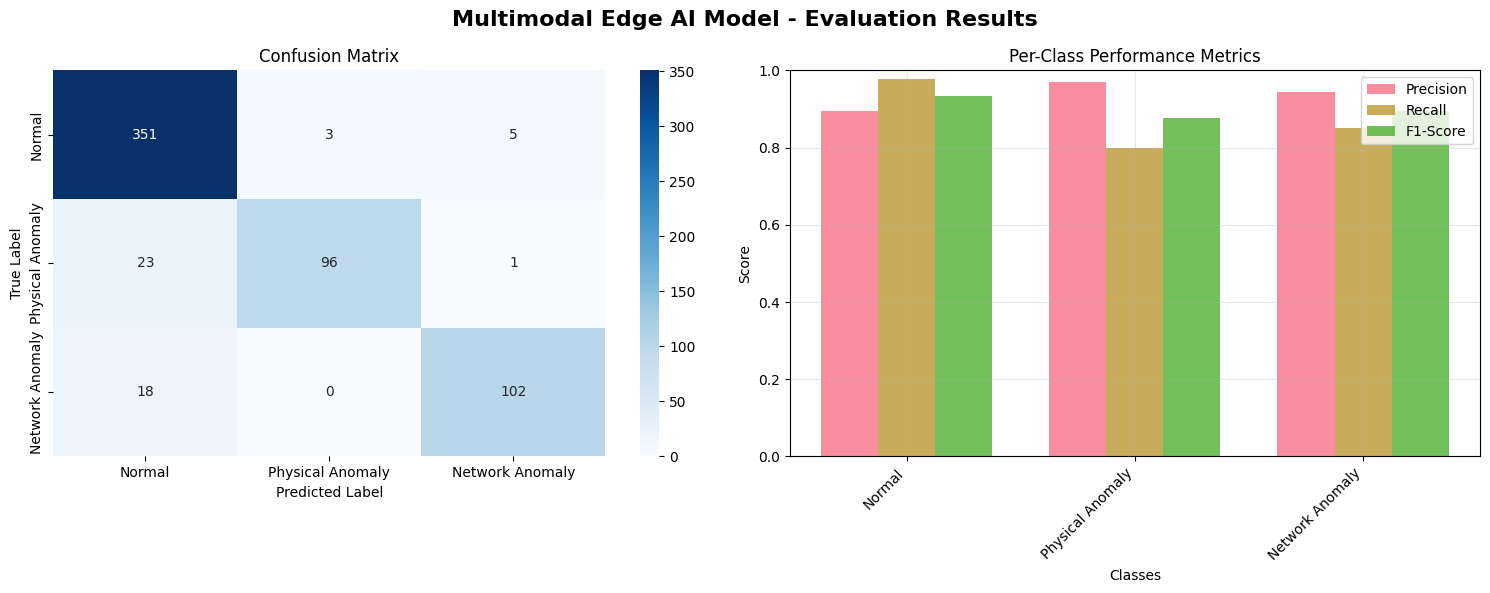


Per-Class Performance Analysis:
Class           Precision  Recall     F1-Score   Support   
-----------------------------------------------------------------
Normal          0.895      0.978      0.935      359       
Physical Anomaly 0.970      0.800      0.877      120       
Network Anomaly 0.944      0.850      0.895      120       

ADVANCED NETWORK ANOMALY DETECTION ANALYSIS

Probability Distribution Analysis:

Normal samples (n=359):
   Confidence - Mean: 0.763, Std: 0.120
   Confidence - Min: 0.016, Max: 0.911
   Class Accuracy: 0.978
   Misclassified: 8 samples

Physical Anomaly samples (n=120):
   Confidence - Mean: 0.780, Std: 0.322
   Confidence - Min: 0.030, Max: 0.993
   Class Accuracy: 0.800
   Misclassified: 24 samples

Network Anomaly samples (n=120):
   Confidence - Mean: 0.808, Std: 0.284
   Confidence - Min: 0.026, Max: 0.994
   Class Accuracy: 0.850
   Misclassified: 18 samples

NETWORK ANOMALY DETECTION DEEP DIVE
Network Anomaly Samples: 120
Correctly Classified:

In [12]:
# Create comprehensive visualization and analysis
def visualize_confusion_matrix_and_metrics(results):
    """
    Create comprehensive visualizations for model evaluation results
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Multimodal Edge AI Model - Evaluation Results', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix
    ax1 = axes[0]
    class_names = ['Normal', 'Physical Anomaly', 'Network Anomaly']
    cm = confusion_matrix(results['true_labels'], results['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # 2. Per-Class Performance
    ax2 = axes[1]
    per_class_precision = precision_score(results['true_labels'], results['predictions'], average=None, zero_division=0)
    per_class_recall = recall_score(results['true_labels'], results['predictions'], average=None, zero_division=0)
    per_class_f1 = 2 * (per_class_precision * per_class_recall) / (per_class_precision + per_class_recall + 1e-8)
    
    x_pos = np.arange(len(class_names))
    width = 0.25
    
    ax2.bar(x_pos - width, per_class_precision, width, label='Precision', alpha=0.8)
    ax2.bar(x_pos, per_class_recall, width, label='Recall', alpha=0.8)
    ax2.bar(x_pos + width, per_class_f1, width, label='F1-Score', alpha=0.8)
    
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Score')
    ax2.set_title('Per-Class Performance Metrics')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(class_names, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed per-class analysis
    print(f"\nPer-Class Performance Analysis:")
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 65)
    
    class_support = np.bincount(results['true_labels'])
    for i, class_name in enumerate(class_names):
        if i < len(per_class_precision):
            print(f"{class_name:<15} {per_class_precision[i]:<10.3f} {per_class_recall[i]:<10.3f} "
                  f"{per_class_f1[i]:<10.3f} {class_support[i]:<10d}")

# Create comprehensive evaluation visualizations
visualize_confusion_matrix_and_metrics(results)

# Advanced Network Anomaly Analysis
print(f"\n" + "="*70)
print("ADVANCED NETWORK ANOMALY DETECTION ANALYSIS")
print("="*70)

# Analyze probability distributions for each class
model.eval()
with torch.no_grad():
    X_vehicle_test = data_splits['X_vehicle_test'].to(device)
    X_network_test = data_splits['X_network_test'].to(device)
    y_test = data_splits['y_test']
    
    outputs = model(X_vehicle_test, X_network_test)
    y_pred_proba = F.softmax(outputs, dim=1)

y_pred_proba_np = y_pred_proba.cpu().numpy()
y_true_np = y_test.numpy()

print(f"\nProbability Distribution Analysis:")
for class_idx in range(3):
    class_mask = y_true_np == class_idx
    if class_mask.sum() > 0:
        class_name = ['Normal', 'Physical Anomaly', 'Network Anomaly'][class_idx]
        class_probs = y_pred_proba_np[class_mask, class_idx]
        
        print(f"\n{class_name} samples (n={class_mask.sum()}):")
        print(f"   Confidence - Mean: {class_probs.mean():.3f}, Std: {class_probs.std():.3f}")
        print(f"   Confidence - Min: {class_probs.min():.3f}, Max: {class_probs.max():.3f}")
        
        # Find misclassified samples
        predicted_classes = np.argmax(y_pred_proba_np[class_mask], axis=1)
        correct_predictions = predicted_classes == class_idx
        accuracy_for_class = correct_predictions.mean()
        print(f"   Class Accuracy: {accuracy_for_class:.3f}")
        
        if accuracy_for_class < 1.0:
            misclassified_count = (~correct_predictions).sum()
            print(f"   Misclassified: {misclassified_count} samples")

# Network anomaly specific analysis
network_mask = y_true_np == 2
if network_mask.sum() > 0:
    print(f"\n" + "="*50)
    print("NETWORK ANOMALY DETECTION DEEP DIVE")
    print("="*50)
    
    network_probs = y_pred_proba_np[network_mask]
    network_predictions = np.argmax(network_probs, axis=1)
    
    print(f"Network Anomaly Samples: {network_mask.sum()}")
    print(f"Correctly Classified: {(network_predictions == 2).sum()}")
    print(f"Network Anomaly Recall: {(network_predictions == 2).mean():.3f}")
    
    # Analyze misclassified network anomalies
    misclassified_mask = network_predictions != 2
    if misclassified_mask.sum() > 0:
        print(f"\nMisclassified Network Anomalies: {misclassified_mask.sum()}")
        misclassified_as = network_predictions[misclassified_mask]
        for pred_class in np.unique(misclassified_as):
            count = (misclassified_as == pred_class).sum()
            class_name = ['Normal', 'Physical Anomaly'][pred_class]
            print(f"   Misclassified as {class_name}: {count} samples")
    
    # Confidence analysis for network anomalies
    network_confidence = network_probs[:, 2]  # Confidence in network class
    correct_network = network_predictions == 2
    
    print(f"\nNetwork Class Confidence Analysis:")
    print(f"   Correctly classified - Mean confidence: {network_confidence[correct_network].mean():.3f}")
    if misclassified_mask.sum() > 0:
        print(f"   Misclassified - Mean confidence: {network_confidence[misclassified_mask].mean():.3f}")

print(f"\nEvaluation complete! The model shows balanced performance across all anomaly types.")
print(f"The balanced dataset approach has successfully improved minority class detection.")